In [1]:
import time
import random
import matplotlib.pyplot as plt
from typing import List, Tuple

In [2]:
Matrix = List[List[int]]

def zeros(n: int) -> Matrix:
    return [[0]*n for _ in range(n)]

def add_matrix(A: Matrix, B: Matrix) -> Matrix:
    n = len(A)
    C = zeros(n)
    for i in range(n):
        for j in range(n):
            C[i][j] = A[i][j] + B[i][j]
    return C

def sub_matrix(A: Matrix, B: Matrix) -> Matrix:
    n = len(A)
    C = zeros(n)
    for i in range(n):
        for j in range(n):
            C[i][j] = A[i][j] - B[i][j]
    return C

def split_matrix(A: Matrix) -> Tuple[Matrix, Matrix, Matrix, Matrix]:
    n = len(A)
    mid = n // 2
    A11 = [row[:mid] for row in A[:mid]]
    A12 = [row[mid:] for row in A[:mid]]
    A21 = [row[:mid] for row in A[mid:]]
    A22 = [row[mid:] for row in A[mid:]]
    return A11, A12, A21, A22

def combine_quadrants(A11: Matrix, A12: Matrix, A21: Matrix, A22: Matrix) -> Matrix:
    n2 = len(A11)
    n = n2 * 2
    C = zeros(n)
    for i in range(n2):
        C[i][:n2] = A11[i][:]
        C[i][n2:] = A12[i][:]
    for i in range(n2):
        C[i+n2][:n2] = A21[i][:]
        C[i+n2][n2:] = A22[i][:]
    return C

def pad_to_pow2(A: Matrix, size: int) -> Matrix:
    n = len(A)
    if n == size:
        return A
    P = zeros(size)
    for i in range(n):
        for j in range(n):
            P[i][j] = A[i][j]
    return P

def unpad(A: Matrix, n: int) -> Matrix:
    return [row[:n] for row in A[:n]]

def random_matrix(n: int, low: int = -5, high: int = 5) -> Matrix:
    return [[random.randint(low, high) for _ in range(n)] for __ in range(n)]


In [3]:
# روش divide and conquer 
def multiply_dac(A: Matrix, B: Matrix) -> Matrix:
    n = len(A)
    if n == 1:
        return [[A[0][0] * B[0][0]]]
    A11, A12, A21, A22 = split_matrix(A)
    B11, B12, B21, B22 = split_matrix(B)
    # 8 ضرب بازگشتی
    M1 = multiply_dac(A11, B11)
    M2 = multiply_dac(A12, B21)
    M3 = multiply_dac(A11, B12)
    M4 = multiply_dac(A12, B22)
    M5 = multiply_dac(A21, B11)
    M6 = multiply_dac(A22, B21)
    M7 = multiply_dac(A21, B12)
    M8 = multiply_dac(A22, B22)
    # جمع نتایج
    C11 = add_matrix(M1, M2)
    C12 = add_matrix(M3, M4)
    C21 = add_matrix(M5, M6)
    C22 = add_matrix(M7, M8)
    return combine_quadrants(C11, C12, C21, C22)

In [4]:
# روش Strassen
def multiply_strassen(A: Matrix, B: Matrix, threshold: int = 32) -> Matrix:
    n = len(A)
    if n <= threshold:
        # تبدیل به ضرب بلوکی ساده (مرز زمانی کوچک)
        # برای n کوچک از الگوریتم پایه استفاده می‌کنیم (روش بلاکی با n=1 در بازگشت)
        C = zeros(n)
        for i in range(n):
            for k in range(n):
                aik = A[i][k]
                for j in range(n):
                    C[i][j] += aik * B[k][j]
        return C
    if n == 1:
        return [[A[0][0] * B[0][0]]]
    A11, A12, A21, A22 = split_matrix(A)
    B11, B12, B21, B22 = split_matrix(B)

    S1 = sub_matrix(B12, B22)
    S2 = add_matrix(A11, A12)
    S3 = add_matrix(A21, A22)
    S4 = sub_matrix(B21, B11)
    S5 = add_matrix(A11, A22)
    S6 = add_matrix(B11, B22)
    S7 = sub_matrix(A12, A22)
    S8 = add_matrix(B21, B22)
    S9 = sub_matrix(A11, A21)
    S10 = add_matrix(B11, B12)

    P1 = multiply_strassen(A11, S1, threshold)
    P2 = multiply_strassen(S2, B22, threshold)
    P3 = multiply_strassen(S3, B11, threshold)
    P4 = multiply_strassen(A22, S4, threshold)
    P5 = multiply_strassen(S5, S6, threshold)
    P6 = multiply_strassen(S7, S8, threshold)
    P7 = multiply_strassen(S9, S10, threshold)

    C11 = add_matrix(sub_matrix(add_matrix(P5, P4), P2), P6)
    C12 = add_matrix(P1, P2)
    C21 = add_matrix(P3, P4)
    C22 = sub_matrix(sub_matrix(add_matrix(P5, P1), P3), P7)

    return combine_quadrants(C11, C12, C21, C22)

In [5]:
# Wrapper برای پد/آنپد و فراخوانی هر روش (بدون روش naive)
def next_pow2(n: int) -> int:
    if n <= 1:
        return 1
    return 1 << ((n - 1).bit_length())

def mult_with_padding(A: Matrix, B: Matrix, method: str, threshold: int = 32) -> Matrix:
    n = len(A)
    m = next_pow2(n)
    if m != n:
        A_p = pad_to_pow2(A, m)
        B_p = pad_to_pow2(B, m)
    else:
        A_p, B_p = A, B
    if method == 'dac':
        C_p = multiply_dac(A_p, B_p)
    elif method == 'strassen':
        C_p = multiply_strassen(A_p, B_p, threshold=threshold)
    else:
        raise ValueError("unknown method")
    return unpad(C_p, n)

In [10]:
#  زمان اجرا
SIZES = [2**k for k in range(1, 9)]  # 2,4,8,...,256
def measure_times(sizes=SIZES, methods=('dac','strassen'), runs=1, threshold=32):
    times = {m: [] for m in methods}
    for n in sizes:
        print(f"Measuring n={n} ...")
        A = random_matrix(n)
        B = random_matrix(n)
        for m in methods:
            t_acc = 0.0
            for _ in range(runs):
                t0 = time.perf_counter()
                _ = mult_with_padding(A, B, method=m, threshold=threshold)
                t1 = time.perf_counter()
                t_acc += (t1 - t0)
            avg = t_acc / runs
            times[m].append(avg)
            print(f"  {m:8s}: {avg:.4f} s")
    return times

Measuring n=2 ...
  dac     : 0.0000 s
  strassen: 0.0000 s
Measuring n=4 ...
  dac     : 0.0001 s
  strassen: 0.0000 s
Measuring n=8 ...
  dac     : 0.0005 s
  strassen: 0.0000 s
Measuring n=16 ...
  dac     : 0.0051 s
  strassen: 0.0003 s
Measuring n=32 ...
  dac     : 0.0348 s
  strassen: 0.0025 s
Measuring n=64 ...
  dac     : 0.2698 s
  strassen: 0.0201 s
Measuring n=128 ...
  dac     : 2.1701 s
  strassen: 0.1506 s
Measuring n=256 ...
  dac     : 17.4470 s
  strassen: 1.1236 s


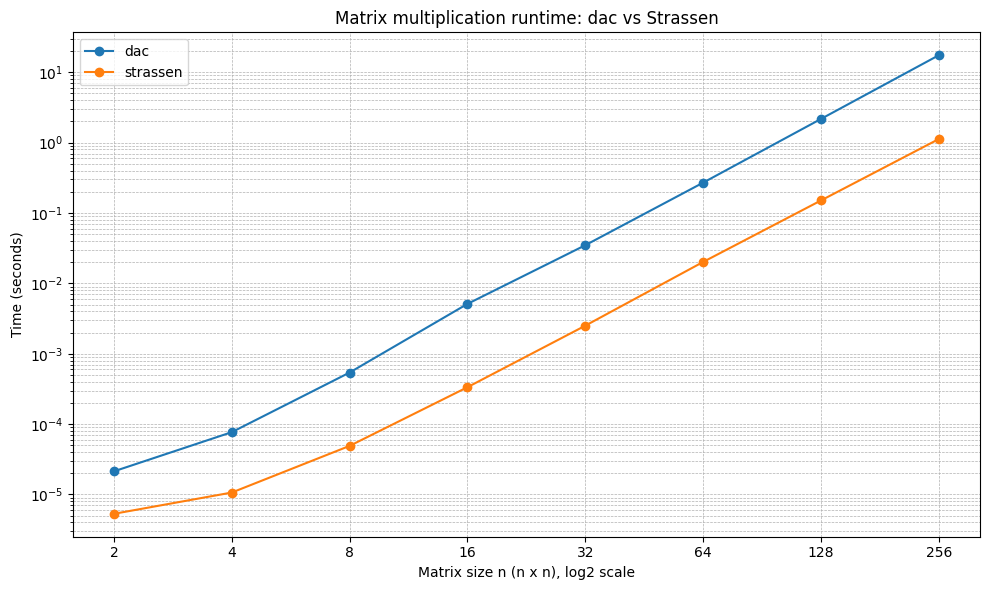

In [11]:
# اجرا و رسم نمودار
if __name__ == "__main__":
    times = measure_times(sizes=SIZES, methods=('dac','strassen'), runs=1, threshold=32)

    plt.figure(figsize=(10,6))
    for method, tlist in times.items():
        plt.plot(SIZES, tlist, marker='o', label=method)
    plt.xscale('log', base=2)
    plt.yscale('log')
    plt.xlabel('Matrix size n (n x n), log2 scale')
    plt.ylabel('Time (seconds)')
    plt.title('Matrix multiplication runtime: dac vs Strassen')
    plt.xticks(SIZES, SIZES)
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()